In [45]:
import numpy as np
from astropy.io import fits
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from photoz_metrics import *

In [47]:
def calculate_conv_outlier_rate(z_photo,z_spec):

# This function calculate the conventional outlier rate. 

    delz = (z_photo - z_spec)/(1+z_spec)
    number_outlier = len(np.where(abs(delz)>0.15)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv

In [48]:
def calculate_biweight_outlier_rate(z_photo,z_spec,b_bw,sigma_bw):
    
# The biweight outlier rate defined in HSC DPR2 paper. 

    delz = (z_photo - z_spec)/(1+z_spec)
    number_outlier = len(np.where(abs(delz-b_bw)>2*sigma_bw)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv
    

In [2]:
def generate_pdf_random_forest(number_estimator,X_train,y_train,X_test):

#number_estimator is an integer for the number of estimators for the random forest model
#X_train is an array for training set of inputs
#y_train is an array for training set of true values
#X_test is an array for testing set for inputs
#the output of this function is the predictions of pdfs of the X_test.
#output is a N x number_estimator array, where N is the number of elements in X_test. 
    
    randomForest = RandomForestRegressor(n_estimators = number_estimator)
    randomForest.fit(X_train, y_train)
    
    predictions = []
    for i in range (number_estimator):
        predictions.append(
        np.array(
        randomForest.estimators_[i].predict(X_test)))
    
    predictions = np.asarray(predictions).T
    predictions = np.sort(predictions, axis = 1)
    
    return predictions

In [3]:
def calculate_PIT(predictions,true_value):

# predictions is a two dimentional array. Each row is a PDF for the estimation of redshift for a galaxy. 
# y_test is an array containing the true_value of redshift for all the galaxies. 
# the ouput of this function is a PIT distribution for all the PDFs. 

    PIT  = np.zeros(len(predictions))
    
    for i in range (len(predictions)):          
        PIT[i] = len(np.where(predictions[i]<true_value[i])[0])*1.0/len(predictions[0])
        
    return PIT

In [16]:
ls

all_specz_flag_forced_forced2_spec_z_matched_online.csv
forced_forced2_spec_z_matched_online.csv
matched_photozdata_with_spectrozdata_full_unfiltered.csv
matched_photozdata_with_spectrozdata_full_unfiltered_readable.csv
spectroscopic_data_only.fits
trimmed_forced_forced2_spec_z_matched_online.csv


In [17]:
photozdata = pd.read_csv('/mnt/data/HSC/HSC_v3/all_specz_flag_forced_forced2_spec_z_matched_online.csv')

In [18]:
photozdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801246 entries, 0 to 801245
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   # object_id         801246 non-null  int64  
 1   specz_redshift_err  801246 non-null  float64
 2   specz_redshift      801246 non-null  float64
 3   specz_mag_i         794360 non-null  float64
 4   specz_name          801246 non-null  object 
 5   specz_ra            801246 non-null  float64
 6   specz_dec           801246 non-null  float64
 7   ra                  801246 non-null  float64
 8   dec                 801246 non-null  float64
 9   coord               801246 non-null  object 
 10  skymap_id           801246 non-null  int64  
 11  g_cmodel_mag        801232 non-null  float64
 12  r_cmodel_mag        801244 non-null  float64
 13  i_cmodel_mag        801244 non-null  float64
 14  z_cmodel_mag        801244 non-null  float64
 15  y_cmodel_mag        801208 non-nul

In [36]:
filt = (photozdata['specz_redshift'] < 4)\
& (photozdata['specz_redshift'] > 0.01)\
& (photozdata['specz_redshift_err'] > 0) \
& (photozdata['specz_redshift_err'] < 1)\
&(photozdata["specz_redshift_err"]<0.005*(1+photozdata["specz_redshift"]))\
&(photozdata['g_cmodel_mag'] >0)\
&(photozdata['r_cmodel_mag'] >0)\
&(photozdata['i_cmodel_mag'] >0)\
&(photozdata['z_cmodel_mag'] >0)\
&(photozdata['y_cmodel_mag'] >0)\
&(photozdata['g_cmodel_mag'] < 50)\
&(photozdata['r_cmodel_mag'] < 50)\
&(photozdata['i_cmodel_mag'] < 50)\
&(photozdata['z_cmodel_mag'] < 50)\
&(photozdata['y_cmodel_mag'] < 50)

photozdata_subset = photozdata[filt]

In [37]:
photozdata_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759526 entries, 1 to 801245
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   # object_id         759526 non-null  int64  
 1   specz_redshift_err  759526 non-null  float64
 2   specz_redshift      759526 non-null  float64
 3   specz_mag_i         753613 non-null  float64
 4   specz_name          759526 non-null  object 
 5   specz_ra            759526 non-null  float64
 6   specz_dec           759526 non-null  float64
 7   ra                  759526 non-null  float64
 8   dec                 759526 non-null  float64
 9   coord               759526 non-null  object 
 10  skymap_id           759526 non-null  int64  
 11  g_cmodel_mag        759526 non-null  float64
 12  r_cmodel_mag        759526 non-null  float64
 13  i_cmodel_mag        759526 non-null  float64
 14  z_cmodel_mag        759526 non-null  float64
 15  y_cmodel_mag        759526 non-nul

In [38]:
y = photozdata_subset['specz_redshift']
X = photozdata_subset[['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag']]

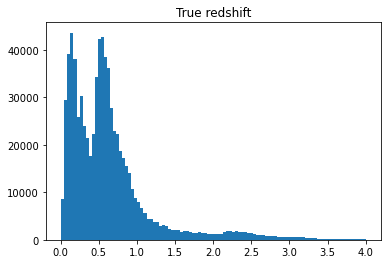

In [39]:
#plot the histogram of true redshift

plt.hist(y,bins = 100)
plt.title("True redshift")
plt.show()

In [40]:
X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [41]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

RandomForestRegressor()

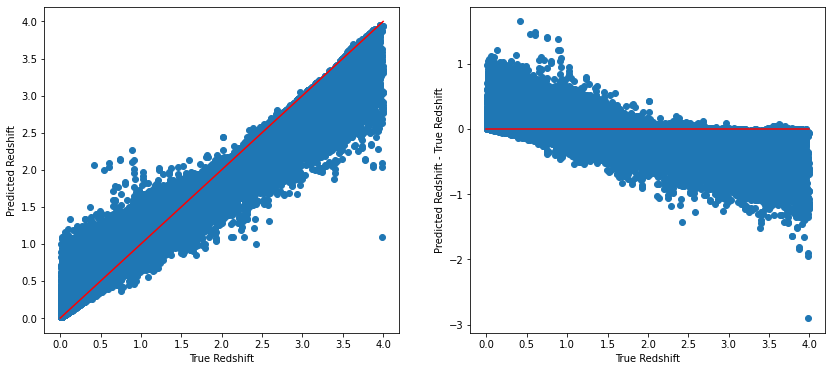

In [42]:
# look at how well the model predicts the traing data
y_train_predict = random_forest_model.predict(X_train)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(y_train,y_train_predict,'o')
plt.ylabel('Predicted Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,4], color='red')
plt.subplot(1,2,2)
plt.plot(y_train,y_train_predict-y_train,'o')
plt.ylabel('Predicted Redshift - True Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,0], color='red')


In [ ]:
from scipy.stats import gaussian_kde
xy = np.vstack([y_train,y_train_predict])
z = gaussian_kde(xy)(xy)

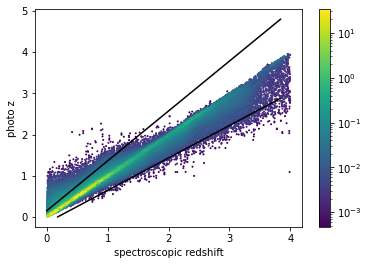

In [55]:
import matplotlib.cm as cm
import matplotlib
fig, ax = plt.subplots()
ax_ = ax.scatter(y_train, y_train_predict, c=z,s = 1,edgecolor=None, norm=matplotlib.colors.LogNorm())
plt.colorbar(ax_)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')

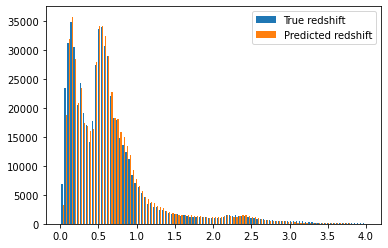

In [43]:
plt.figure()
plt.hist([y_train,y_train_predict],bins = 100)
plt.legend(["True redshift","Predicted redshift"])
plt.show()

In [57]:
b_bw = calculate_bias(y_train_predict,y_train)
sigma_bw = calculate_scatter(y_train_predict,y_train)
outlier_rate = calculate_biweight_outlier_rate(y_train_predict,y_train,b_bw,sigma_bw)
loss_function = calculate_loss(y_train_predict,y_train)
conv_outlier_rate = calculate_conv_outlier_rate(y_train_predict,y_train)


average_loss = sum(loss_function)/len(loss_function)


print ("bias: %s"%(b_bw))
print("scatter: %s"%(sigma_bw))
print("biweighht outlier rate: %s"%(outlier_rate))
print("conventional outlier rate: %s"%(conv_outlier_rate))
print("average loss: %s"%(average_loss))

bias: 0.0004963215826582444
scatter: 0.011809723164258736
biweighht outlier rate: 0.18898489187321024
conventional outlier rate: 0.02208123498239031
average loss: 0.039800720031941184


In [126]:
#predictions = generate_pdf_random_forest(100,X_train,y_train,X_test)

In [139]:
#y_test = np.asarray(y_test)

In [141]:
#PIT = calculate_PIT(predictions,y_test)

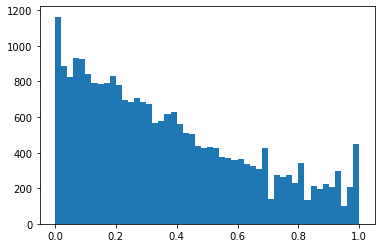

In [144]:
#plt.hist(PIT,bins = 50)
#plt.show()